# 0_segment_and_label

## Dataset creation, segmentation and peak labelling

During the experiment, we collected a lot of pictures with the detector. These pictures are mainly empty except for diffraction peaks. The first step consists in segmenting these images to keep only the peaks, their position on the detector and their intensities.


Written by James Ball, Haixing Fang and Jon Wright

Last updated: 21/02/2025

Outside ESRF: download [install_ImageD11_from_git.py](https://github.com/FABLE-3DXRD/ImageD11/tree/master/ImageD11/nbGui/install_ImageD11_from_git.py), and update the path in the next cell:

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

The notebooks are written with all the parameters in the first cell.
We will see how to tune these parameters along the notebook.

For now, change : 
1. the dataset name (*dset_path*)
2. the major phase name (*major_phase_strs*), this is a list [] because you may want to filter the major phase and other minor phases you already indexed
3. the minor phase name (*minor_phase_str*)

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

PYTHONPATH = setup_ImageD11_from_git( os.path.join( os.environ['HOME'],'Code', 'Tutorial', 'SCRIPTS'), 'ImageD11' ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# Experts : update these files for your detector if you need to
maskfile = "mask_with_gaps_E-08-0173.edf"
e2dxfile = "e2dx_E-08-0144_20240205.edf"
e2dyfile = "e2dy_E-08-0144_20240205.edf"
detector = 'eiger'
omegamotor = 'rot_center'
dtymotor = 'dty'

# Default segmentation options
options = { 'cut' : 1, 'pixels_in_spot' : 3, 'howmany' : 100000 }
normalise_intensities_to_monitor = True
monitor_name = 'fpico6'

# EXPERTS: These can be provided as papermill parameters. Users, leave these as None for now...
dataroot = '/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA'
analysisroot = '/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ'
sample = "FeAu_0p5_tR_nscope" 
dataset = "top_200um"

# Setting path via: 
sys.path.insert(0, /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11 )


# Running from: /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/__init__.py


In [3]:
# Import needed packages
import pprint
import numpy as np
from matplotlib import pyplot as plt

import ImageD11.sinograms.dataset
import ImageD11.sinograms.lima_segmenter
import ImageD11.sinograms.assemble_label
import ImageD11.sinograms.properties
import ImageD11.nbGui.nb_utils as utils
from ImageD11.nbGui import segmenter_gui

# %matplotlib ipympl

Set up the file paths. Edit this if you are not at ESRF or not using the latest data policy.

In [4]:
if dataroot is None:
    dataroot, analysisroot = segmenter_gui.guess_ESRF_paths() 

if len(dataroot)==0:
    print("Please fix in the dataroot and analysisroot folder names above!!")
    
print('dataroot =',repr(dataroot))
print('analysisroot =',repr(analysisroot))

dataroot = '/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA'
analysisroot = '/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ'


In [5]:
# List the samples available:
segmenter_gui.printsamples(dataroot)

Samples:
	 .ipynb_checkpoints
	FeAu_0p5_tR_nscope


In [6]:
# USER: Decide which sample
if sample is None:
    sample = 'FeAu_0p5_tR_nscope'

In [7]:
# List the datasets for that sample:
segmenter_gui.printdatasets( dataroot, sample )

Datsets:
	 top_200um
	top_250um


In [8]:
# USER: Decide which dataset
if dataset is None:
    dataset = "top_200um"

## Example demo to see how a frame is segmented for one dataset:

Create ImageD11 dataset object

In [9]:
dataroot

'/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA'

In [10]:
ds = ImageD11.sinograms.dataset.DataSet(dataroot=dataroot,
                                        analysisroot=analysisroot,
                                        sample=sample,
                                        dset=dataset,
                                        detector=detector,
                                        omegamotor=omegamotor,
                                        dtymotor=dtymotor
                                       )
ds.import_all()  # Can use scans = [f'{scan}.1' for scan in range(1,102)] )
ds.maskfile = maskfile
ds.e2dxfile = e2dxfile
ds.e2dyfile = e2dyfile
ds.save()

You should now see two pictures, n the left the raw image, and on the right the segmented image. 
By zooming in the picture, you can see the spots and the background noise more clearly.

You can change `frame` to select a different frame if you are unlucky and don't see any spot on the current frame.

In [11]:
ui = segmenter_gui.SegmenterGui(ds, frame = 460, **options )

Using frame 460 from scan 138.1


interactive(children=(IntSlider(value=1, description='Cut:', max=200), IntSlider(value=3, description='Pixels …

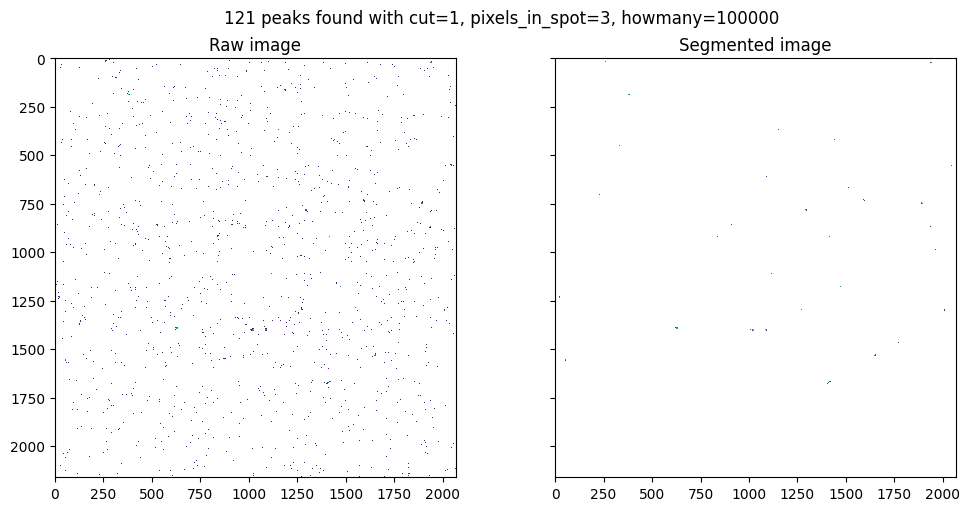

In [12]:
segmenter_gui.SegmenterGui.display(ui)

Make sure the printed options below are the one you selected

In [13]:
options = ui.getopts()

options =  {'cut': 1, 'pixels_in_spot': 3, 'howmany': 100000}


# Sparse file creation

Create a batch file to send to the ESRF SLURM cluster.

In [14]:
# sbat = ImageD11.sinograms.lima_segmenter.setup(ds.dsfile, **ui.getopts(), pythonpath=PYTHONPATH)
# if sbat is None:
#     raise ValueError("This scan has already been segmented!")
# print(sbat)

In [15]:
# utils.slurm_submit_and_wait(sbat, 60)

# Peak labeling

Once all images are segmented :
1. every peak is labeled,
2. a peak table is generated.

In [16]:
# ImageD11.sinograms.assemble_label.main(ds.dsfile)

In [17]:
# ImageD11.sinograms.properties.main(ds.dsfile, options={'algorithm': 'lmlabel', 'wtmax': 70000, 'save_overlaps': False})

# Intensity normalisation
At the ESRF, there is a refill of electrons every hour. The intensity of the signal may change for during long scans
You can optionally normalise your observed intensities to a monitor column, such as a pico, if you had one in the beam path.


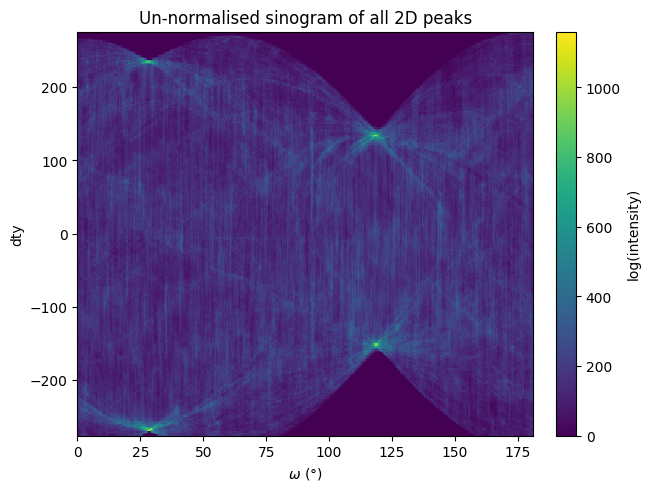

In [18]:
fig, ax = plt.subplots(layout='constrained')
im, om_edges, dty_edges = ds.sinohist(np.log(ds.pk2d['sum_intensity']), ds.pk2d['omega'], ds.pk2d['dty'], return_edges=True)
pcm = ax.pcolormesh(om_edges, dty_edges, im.T)
ax.set(xlabel=r'$\omega~(\degree)$', ylabel='dty', title='Un-normalised sinogram of all 2D peaks')
cax = fig.colorbar(pcm, ax=ax, label='log(intensity)')
plt.show()

Let's look at an image of the monitor signal across (dty, omega)

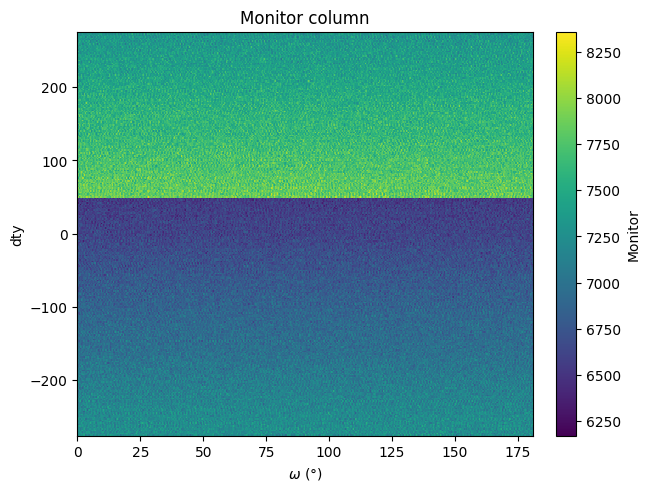

In [19]:
if normalise_intensities_to_monitor:
    monitor_per_frame = ds.get_monitor(monitor_name)

    fig, ax = plt.subplots(layout='constrained')
    pcm = ax.pcolormesh(om_edges, dty_edges, monitor_per_frame)
    ax.set(xlabel=r'$\omega~(\degree)$', ylabel='dty', title='Monitor column')
    cax = fig.colorbar(pcm, ax=ax, label='Monitor')
    plt.show()

To normalise to a monitor signal, we need to choose a "reference" monitor value that we scale to.
A good choice may be `np.mean(monitor_per_frame)`

We then compute `scale_factor_per_frame = np.mean(monitor_per_frame) / monitor_per_frame`  
We then multiply the observed intensities by `scale_factor_per_frame`

You can choose which function to use to generate the "reference" monitor value, for example:

`ds.set_monitor(monitor_name='fpico6', ref_value_func=np.mean)`

/home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/sinograms/dataset.py:672: UserWarning: Clearing cached pk2d
  warnings.warn("Clearing cached pk2d")
/home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/sinograms/dataset.py:684: UserWarning: I found an existing 4D colfile on disk - you probably want to remake this with ds.get_cf_4d(ignore_existing=True)
  warnings.warn("I found an existing 4D colfile on disk - you probably want to remake this with ds.get_cf_4d(ignore_existing=True)")


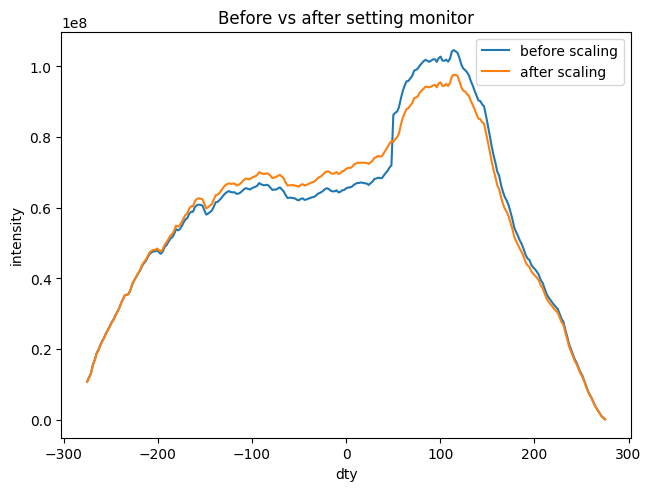

In [20]:
if normalise_intensities_to_monitor:
    # ensure no monitor currently set
    ds.monitor = None
    ds.monitor_ref = None
    ds.reset_peaks_cache()

    fig, ax = plt.subplots(layout='constrained')
    im, om_edges, dty_edges = ds.sinohist(ds.pk2d['sum_intensity'], ds.pk2d['omega'], ds.pk2d['dty'], return_edges=True)
    ax.plot(dty_edges, im.sum(axis=0), label='before scaling')
    
    # here we set the monitor
    ds.set_monitor(monitor_name, ref_value_func=np.mean)

    im, om_edges, dty_edges = ds.sinohist(ds.pk2d['sum_intensity'], ds.pk2d['omega'], ds.pk2d['dty'], return_edges=True)
    ax.plot(dty_edges, im.sum(axis=0), label='after scaling')
    ax.legend()
    ax.set(xlabel='dty', ylabel='intensity', title='Before vs after setting monitor')
    plt.show()
    
    # save the choice of monitor to disk
    ds.save()

# Finished segmenting!

You can now choose between two different indexing routes: tomographic (tomo) and point-by-point (pbp).  
Tomo gives you better grain shapes, but can't handle highly deformed samples.  
Point-by-point can only give you convex grain shapes (less accurate) but can handle high levels of deformation.  
Both techniques will join back together during the strain refinement stage (notebook 3).  
Therefore notebooks 4 and onwards should work from either the tomo or pbp route.